In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install bioread numpy pandas
import pandas as pd
import numpy as np
import bioread
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

### Getting R peaks from ACQ FILES

Converting ACQ files to CSV

In [ ]:
import bioread
import pandas as pd
import numpy as np

# Load .acq file with bioread and handle endianness
def acq_to_df(filename):
    try:
        # Read .acq file using bioread
        acq_data = bioread.read_file(filename)

        # Convert channels to a DataFrame
        data = {}
        for channel in acq_data.channels:
            # Ensure endianness compatibility using numpy
            if channel.data.dtype.byteorder not in ('=', '|'):
                channel_data = np.asarray(channel.data).byteswap().newbyteorder()
            else:
                channel_data = channel.data

            # Add channel data to dictionary
            data[channel.name] = channel_data

        # Create DataFrame
        df = pd.DataFrame(data)
        return df
    except Exception as e:
        print(f"Error converting {filename}: {e}")
        return None


In [ ]:
def proces_r_peaks(df):
    # Picking the right column
    r_peaks=df['ECG R-R']
    # Find the first non-zero element
    first_non_zero_index = r_peaks[r_peaks != 0].first_valid_index()
    # Slice the Series from the first non-zero element
    r_peaks = r_peaks[first_non_zero_index:]


    # As R_peaks seams to repeat themselves many times, I assume that they correspond to
    # the same R peak. I will remove the consecutive repetitions and stick only to true
    # r_peaks -

    indices= df['ECG R-R'] != df['ECG R-R'].shift(1)
    indices = indices[indices == True].index[1:]

    segments = []
    # Loop through the indices to create segments
    for i in range(len(indices) - 1):
        start_idx = indices[i]
        end_idx = indices[i + 1]-1
        segment = r_peaks.loc[start_idx:end_idx]
        segments.append(segment)

    # saving only first value of a segment, where segment is a sequence of repeated values

    return pd.Series(np.array([x.values[0] for x in segments]).cumsum())

In [ ]:
# Not used
# def remove_consecutive_duplicates(series):
#     result = [series[0]]  # Start with the first element

#     for element in series[1:]:
#         if element != result[-1]:  # Add to result if different from the last element
#             result.append(element)

#     return result

### Converting ACQ TO CSV

In [ ]:
# Set directories
base_dir = "/content/drive/MyDrive/DeepDream/grudzien02/"  # Update this path to where your files are stored

# List all .csv files in the directory
csv_files = [f for f in os.listdir(base_dir) if f.endswith('.csv')]

# Process .acq files and convert to .csv
acq_files = [f for f in os.listdir(base_dir) if f.endswith('.acq')]

# Convert .acq files to .csv
for f in acq_files:
    df = acq_to_df(os.path.join(base_dir, f))  # Use the acq_to_df function
    if df is not None:
        csv_path = os.path.join(base_dir, f.replace(".acq", ".csv"))
        df.to_csv(csv_path, index=False, sep=";")
        print(f"Converted {f} to {csv_path}")

# Refresh the list of .csv files after conversion
csv_files = [f for f in os.listdir(base_dir) if f.endswith('.csv')]

# Define categories and initialize a dictionary
participant_data = {
    "questions_data": None,
    "device_data": None,
    "heart_baseline_data": None,
    "heart_experiment_data": None,
}

# Map files to categories
file_mapping = {
    "1_QuestionsData.csv": "questions_data",
    "1_DeviceData.csv": "device_data",
    "2_baseline.csv": "heart_baseline_data",
    "1_experiment.csv": "heart_experiment_data",
}

# Function to read and organize data into dictionary
def load_files_to_dict(files, mapping, base_dir):
    data_dict = {}
    for file in files:
        category = mapping.get(file)
        if category:
            try:
                # Read CSV file
                file_path = os.path.join(base_dir, file)
                df = pd.read_csv(file_path, sep=";")
                df = df.rename(columns={"ExperimentSecond": "SystemTime"})
                # Save DataFrame to the appropriate category
                data_dict[category] = df
                print(f"Loaded {file} into {category}.")
            except Exception as e:
                print(f"Error loading {file}: {e}")
    return data_dict

# Load files into participant_data dictionary
participant_data = load_files_to_dict(csv_files, file_mapping, base_dir)

Converted 2_baseline.acq to /content/drive/MyDrive/DeepDream/grudzien02/2_baseline.csv
Converted 1_experiment.acq to /content/drive/MyDrive/DeepDream/grudzien02/1_experiment.csv
Loaded 1_DeviceData.csv into device_data.
Loaded 1_QuestionsData.csv into questions_data.
Loaded 2_baseline.csv into heart_baseline_data.
Loaded 1_experiment.csv into heart_experiment_data.


### Questions


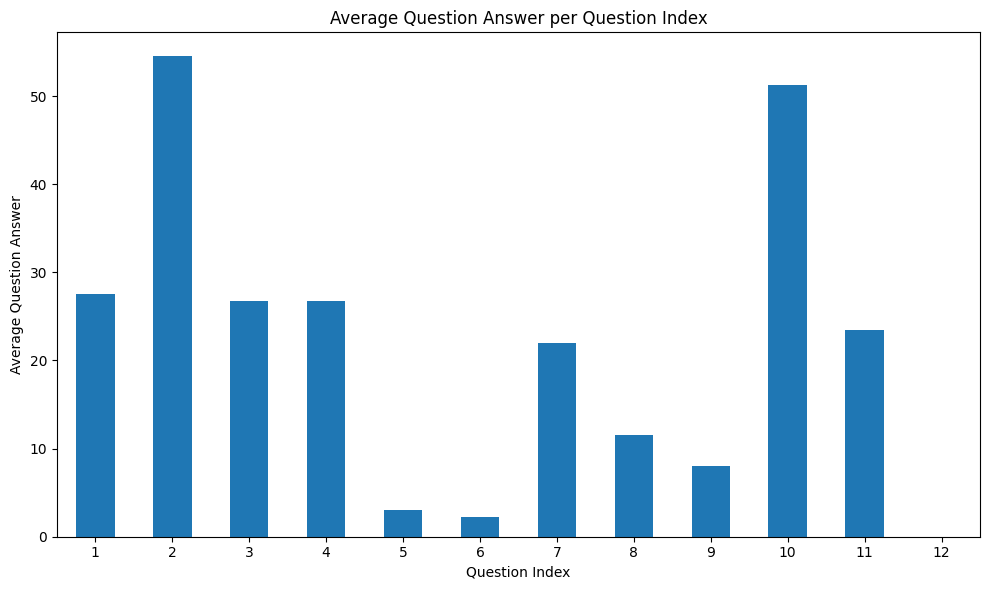

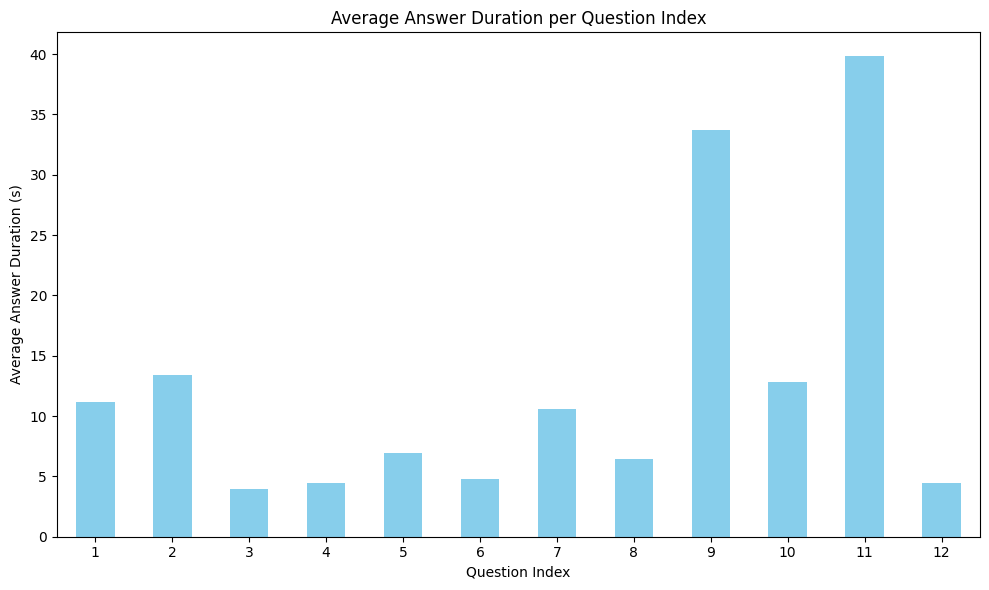

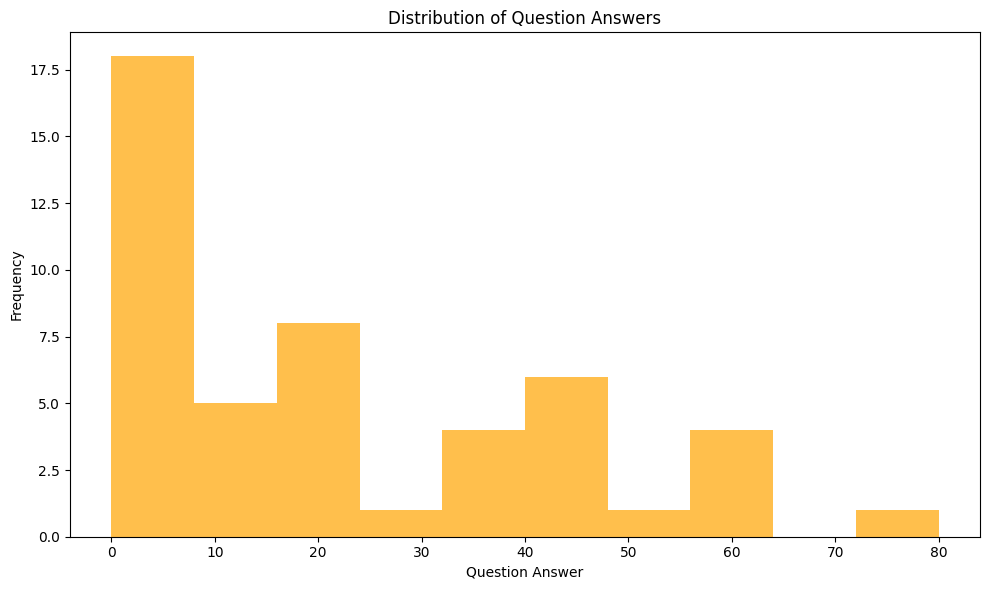

<Figure size 1200x600 with 0 Axes>

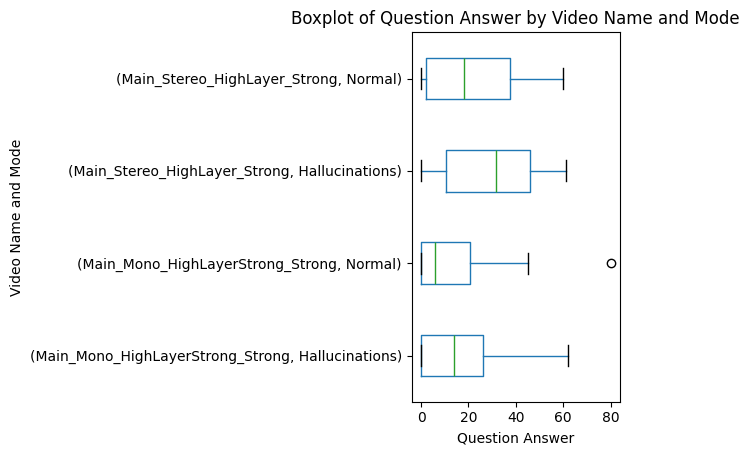

In [ ]:
questions_data = participant_data["questions_data"]

# Bar chart for average QuestionAnswer per QuestionIndex
avg_question_answer = questions_data.groupby("QuestionIndex")["QuestionAnswer"].mean()

plt.figure(figsize=(10, 6))
avg_question_answer.plot(kind="bar")
plt.title("Average Question Answer per Question Index")
plt.xlabel("Question Index")
plt.ylabel("Average Question Answer")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Line/bar chart for AnswerDuration per QuestionIndex
answer_duration = questions_data.groupby("QuestionIndex")["AnswerDuration"].mean()

plt.figure(figsize=(10, 6))
answer_duration.plot(kind="bar", color='skyblue')
plt.title("Average Answer Duration per Question Index")
plt.xlabel("Question Index")
plt.ylabel("Average Answer Duration (s)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Histogram of QuestionAnswer to understand the spread of answers
plt.figure(figsize=(10, 6))
questions_data["QuestionAnswer"].plot(kind="hist", bins=10, alpha=0.7, color='orange')
plt.title("Distribution of Question Answers")
plt.xlabel("Question Answer")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Boxplot comparing QuestionAnswer across VideoName and VideoMode
plt.figure(figsize=(12, 6))
questions_data.boxplot(column="QuestionAnswer", by=["VideoName", "VideoMode"], vert=False, grid=False)
plt.title("Boxplot of Question Answer by Video Name and Mode")
plt.suptitle("")  # Remove the automatic subtitle
plt.xlabel("Question Answer")
plt.ylabel("Video Name and Mode")
plt.tight_layout()
plt.show()

In [ ]:
# Generate a dictionary pairing SegmentIndex with VideoName and VideoMode
segment_video_mapping = (
    questions_data
    .groupby("SegmentIndex")[["VideoName", "VideoMode"]]
    .first()
    .apply(lambda row: {"VideoName": row["VideoName"], "VideoMode": row["VideoMode"]}, axis=1)
    .to_dict()
)

# Print the resulting dictionary
pd.DataFrame(segment_video_mapping).T

,VideoName,VideoMode
1,Main_Stereo_HighLayer_Strong,Normal
2,Main_Stereo_HighLayer_Strong,Hallucinations
3,Main_Mono_HighLayerStrong_Strong,Normal
4,Main_Mono_HighLayerStrong_Strong,Hallucinations


In [ ]:
segment_video_mapping

{1: {'VideoName': 'Main_Stereo_HighLayer_Strong', 'VideoMode': 'Normal'},
 2: {'VideoName': 'Main_Stereo_HighLayer_Strong',
  'VideoMode': 'Hallucinations'},
 3: {'VideoName': 'Main_Mono_HighLayerStrong_Strong', 'VideoMode': 'Normal'},
 4: {'VideoName': 'Main_Mono_HighLayerStrong_Strong',
  'VideoMode': 'Hallucinations'}}

In [ ]:
print(participant_data["device_data"].columns)
participant_data["device_data"].head()

Index(['Id', 'SegmentIndex', 'VideoName', 'VideoMode', 'QuestionIndex',
       'SystemTime', 'DevicePosition', 'DeviceRotation',
       'CombinedEyeDirection', 'CombinedEyeOrigin', 'LeftEyeOpeness',
       'LeftEyeOrigin', 'LeftEyeDirection', 'LeftEyePositionInSensorArea',
       'LeftEyePupilSize', 'RightEyeOpeness', 'RightEyeOrigin',
       'RightEyeDirection', 'RightEyePositionInSensorArea',
       'RightEyePupilSize', 'Phase', 'Luminosity', 'Unnamed: 22'],
      dtype='object')


,Id,SegmentIndex,VideoName,VideoMode,QuestionIndex,SystemTime,DevicePosition,DeviceRotation,CombinedEyeDirection,CombinedEyeOrigin,...,LeftEyePositionInSensorArea,LeftEyePupilSize,RightEyeOpeness,RightEyeOrigin,RightEyeDirection,RightEyePositionInSensorArea,RightEyePupilSize,Phase,Luminosity,Unnamed: 22
0,1,0,NaN,NaN,0,0.036,"(0.278, 1.847, -0.238)","(2.446, 3.239, 4.385)","(-0.138, 0.071, 0.988)","(4.205, -5.730, -19.968)",...,"(0.486, 0.665, 0.000)",4.87,1.0,"(-28.067, -7.351, -18.217)","(0.053, 0.082, 0.995)","(0.418, 0.711, 0.000)",4.91,NaN,0.0,NaN
1,1,1,Main_Stereo_HighLayer_Strong,Normal,0,0.086,"(0.276, 1.846, -0.238)","(2.431, 3.247, 4.589)","(0.051, 0.062, 0.997)","(-28.135, -7.391, -18.305)",...,"(0.486, 0.667, 0.000)",4.94,1.0,"(-28.136, -7.391, -18.305)","(0.051, 0.062, 0.997)","(0.421, 0.717, 0.000)",4.98,Countdown,0.0,NaN
2,1,1,Main_Stereo_HighLayer_Strong,Normal,0,0.086,"(0.276, 1.846, -0.238)","(2.431, 3.247, 4.589)","(0.051, 0.062, 0.997)","(-28.135, -7.391, -18.305)",...,"(0.486, 0.667, 0.000)",4.94,1.0,"(-28.136, -7.391, -18.305)","(0.051, 0.062, 0.997)","(0.421, 0.717, 0.000)",4.98,Countdown,0.0,NaN
3,1,1,Main_Stereo_HighLayer_Strong,Normal,0,0.112,"(0.257, 1.841, -0.229)","(3.358, 3.034, 7.265)","(0.058, 0.064, 0.996)","(-28.181, -7.376, -18.317)",...,"(0.487, 0.666, 0.000)",4.94,1.0,"(-28.181, -7.376, -18.317)","(0.058, 0.064, 0.996)","(0.421, 0.716, 0.000)",5.01,Countdown,0.0,NaN
4,1,1,Main_Stereo_HighLayer_Strong,Normal,0,0.136,"(0.262, 1.842, -0.230)","(3.295, 3.033, 6.756)","(0.063, 0.064, 0.996)","(-28.218, -7.356, -18.361)",...,"(0.490, 0.661, 0.000)",4.98,1.0,"(-28.218, -7.356, -18.361)","(0.063, 0.064, 0.996)","(0.421, 0.716, 0.000)",5.01,Countdown,0.0,NaN


In [ ]:
participant_data["heart_experiment_data"].head()

,"ECG B, X, ECG2-R",Digital input,EVENT,ECG R-R,Heart Rate
0,-0.045471,0.0,0.0,0.0,0.0
1,-0.036011,0.0,0.0,0.0,0.0
2,-0.033264,0.0,0.0,0.0,0.0
3,-0.039673,0.0,0.0,0.0,0.0
4,-0.048523,0.0,0.0,0.0,0.0


### Handling time in the datasets

In [ ]:
def clean_and_add_time_to_ecg(ecg_data, initial_system_time, sampling_rate=1000):
    """
    Cleans ECG data and adjusts its time relative to the initial system time.

    Args:
        ecg_data (pd.DataFrame): Raw ECG data.
        initial_system_time (float): The starting time for alignment.
        sampling_rate (float): The sampling rate of the ECG data (in Hz).

    Returns:
        pd.DataFrame: Cleaned ECG data with adjusted system time.
    """
    # Ensure EVENT column is numeric
    ecg_data["EVENT"] = pd.to_numeric(ecg_data["EVENT"], errors="coerce")

    # Replace invalid or missing values with NaN
    ecg_data.replace(-1, np.nan, inplace=True)

    # Add systemTime based on initial_system_time and sampling_rate
    time_increment = 1 / sampling_rate  # Time step between samples
    ecg_data["SystemTime"] = ecg_data.index * time_increment + initial_system_time

    return ecg_data


def when_event_changed(ecg_data):
    ecg_data["video_start"] = (ecg_data["EVENT"] == 4) & (ecg_data["EVENT"].shift(1) != 4)
    ecg_data["video_end"] = (ecg_data["EVENT"] == 8) & (ecg_data["EVENT"].shift(1) != 8)
    result = ecg_data[(ecg_data["video_start"]) | (ecg_data["video_end"])]

    video_start = result.loc[result["video_start"], "SystemTime"]
    video_end = result.loc[result["video_end"], "SystemTime"]

    print("Video Start Times:", video_start.tolist())
    print("Video End Times:", video_end.tolist())

    return result
def when_segment_changed(device_data):
    device_data["SegmentChanged"] = device_data["SegmentIndex"] != device_data["SegmentIndex"].shift(1)
    result = device_data[device_data["SegmentChanged"]]
    return result["SystemTime"].tolist()
def when_movie_mode_changed(device_data):
    name_changes = device_data["VideoName"].ne(device_data["VideoName"].shift(1))
    mode_changes = device_data["VideoMode"].ne(device_data["VideoMode"].shift(1))
    changes = name_changes | mode_changes

    change_rows = device_data.loc[changes]
    return change_rows
# Combine all changes
def combine_changes(segment_changed, video_start_ecg, video_end_ecg, movie_mode_changes):
    df_segment = pd.DataFrame({"time": segment_changed, "event": "Segment Change (deviceData)"})
    df_video_start = pd.DataFrame({"time": video_start_ecg, "event": "Video Start (ECG)"})
    df_video_end = pd.DataFrame({"time": video_end_ecg, "event": "Video End (ECG)"})
    df_movie_mode = pd.DataFrame({"time": movie_mode_changes["SystemTime"], "event": "Movie/Mode Change (deviceData)"})

    combined = pd.concat([df_segment, df_video_start, df_video_end, df_movie_mode])
    return combined.sort_values("time")

def plot_time_events(changes_combined, segment_changed, video_start_ecg, video_end_ecg, movie_mode_changes):
    sns.scatterplot(data=changes_combined, x="time", y="event", hue="event", s=100)

    for time in segment_changed:
        plt.axvline(x=time, color="blue", linestyle="--", alpha=0.5)
    for time in video_start_ecg:
        plt.axvline(x=time, color="green", linestyle=":", alpha=0.5)
    for time in video_end_ecg:
        plt.axvline(x=time, color="red", linestyle="-", alpha=0.5)

    plt.title("Time Event Plot")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Event Type")
    plt.legend()
    plt.show()


In [ ]:
# Align ECG data with the initial system time of the device data
initial_system_time = participant_data["device_data"]["SystemTime"].iloc[0]  # Get the first system time
participant_data["heart_experiment_data"] = clean_and_add_time_to_ecg(participant_data["heart_experiment_data"], initial_system_time,1000)

participant_data["heart_experiment_data"].head()


,"ECG B, X, ECG2-R",Digital input,EVENT,ECG R-R,Heart Rate,SystemTime
0,-0.045471,0.0,0.0,0.0,0.0,0.036
1,-0.036011,0.0,0.0,0.0,0.0,0.037
2,-0.033264,0.0,0.0,0.0,0.0,0.038
3,-0.039673,0.0,0.0,0.0,0.0,0.039
4,-0.048523,0.0,0.0,0.0,0.0,0.040


Video Start Times: [79.751, 459.646, 905.608, 1245.72]
Video End Times: [321.183, 701.1279999999999, 1147.353, 1487.371]
Video Start Times (ECG): [79.751, 459.646, 905.608, 1245.72]
Video End Times (ECG): [321.183, 701.1279999999999, 1147.353, 1487.371]
Segment Changed Times: [0.036, 0.086, 381.624, 825.827, 1163.72]


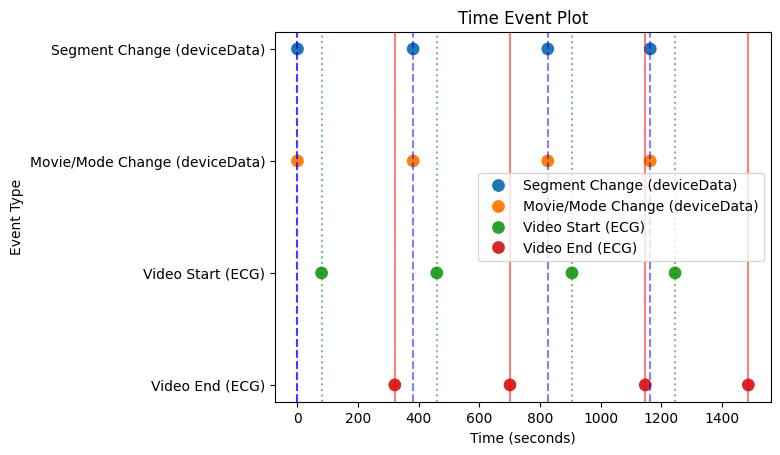

In [ ]:
event_changes = when_event_changed(participant_data["heart_experiment_data"])
video_start_ecg = event_changes.loc[event_changes["video_start"], "SystemTime"].tolist()
video_end_ecg = event_changes.loc[event_changes["video_end"], "SystemTime"].tolist()

print("Video Start Times (ECG):", video_start_ecg)
print("Video End Times (ECG):", video_end_ecg)

segment_changed_times = when_segment_changed(participant_data["device_data"])
print("Segment Changed Times:", segment_changed_times)

movie_mode_changes = when_movie_mode_changed(participant_data["device_data"])
# print("Movie/Mode Change Times:")
# print(movie_mode_changes)

changes_combined = combine_changes(segment_changed_times, video_start_ecg, video_end_ecg, movie_mode_changes)
plot_time_events(changes_combined, segment_changed_times, video_start_ecg, video_end_ecg, movie_mode_changes)



### Eye Tracking

In [ ]:
def calculate_smoothed_pupil_size(device_data, window=180):
    """
    Calculate smoothed pupil size columns for right and left eyes.

    Args:
        device_data (pd.DataFrame): DataFrame containing pupil size columns.
        window (int): Rolling window size for smoothing (default is 180).

    Returns:
        pd.DataFrame: DataFrame with added smoothed pupil size columns.
    """
    # Check if required columns exist
    if "RightEyePupilSize" in device_data.columns and "LeftEyePupilSize" in device_data.columns:
        # Ensure numeric data types
        device_data["RightEyePupilSize"] = pd.to_numeric(device_data["RightEyePupilSize"], errors="coerce")
        device_data["LeftEyePupilSize"] = pd.to_numeric(device_data["LeftEyePupilSize"], errors="coerce")

        # Calculate rolling mean
        device_data["SmoothedRightPupilSize"] = device_data["RightEyePupilSize"].rolling(window=window, min_periods=1).mean()
        device_data["SmoothedLeftPupilSize"] = device_data["LeftEyePupilSize"].rolling(window=window, min_periods=1).mean()
    else:
        print("RightEyePupilSize or LeftEyePupilSize columns are missing in the DataFrame.")
        print("Columns in DataFrame:", device_data.columns)

    return device_data

def calculate_average_pupil_size(device_data):
    """
    Calculate the average pupil size column for the device data.

    Args:
        device_data (pd.DataFrame): DataFrame containing smoothed pupil size columns.

    Returns:
        pd.DataFrame: DataFrame with the added 'average_pupil_size' column.
    """
    # Check if the smoothed pupil size columns exist
    if "SmoothedRightPupilSize" in device_data.columns and "SmoothedLeftPupilSize" in device_data.columns:
        # Calculate the average pupil size
        device_data["AverageSmoothedPupilSize"] = device_data[
            ["SmoothedRightPupilSize", "SmoothedLeftPupilSize"]
        ].mean(axis=1)
    else:
        print("SmoothedRightPupilSize or SmoothedLeftPupilSize columns are missing in the DataFrame.")
        print("Columns in DataFrame:", device_data.columns)

    return device_data


In [ ]:
participant_data["device_data"] = calculate_smoothed_pupil_size(participant_data["device_data"], window=180)
participant_data["device_data"] = calculate_average_pupil_size(participant_data["device_data"])

In [ ]:
def plot_smoothed_pupil_size(device_data, video_start_ecg, video_end_ecg, include_luminosity=False, window=180):
    """
    Plot smoothed pupil sizes and optionally overlay dynamically smoothed Luminosity.

    Args:
        device_data (pd.DataFrame): DataFrame containing smoothed pupil size columns.
        video_start_ecg (list): List of video start times.
        video_end_ecg (list): List of video end times.
        include_luminosity (bool): Whether to dynamically smooth and include Luminosity in the plot (default=False).
        window (int): Rolling window size for smoothing Luminosity (default=180).

    Returns:
        None
    """
    plt.figure(figsize=(12, 6))

    # Plot smoothed right and left pupil sizes
    plt.plot(device_data["SystemTime"], device_data["SmoothedRightPupilSize"], label="Right Eye", color="blue")
    plt.plot(device_data["SystemTime"], device_data["SmoothedLeftPupilSize"], label="Left Eye", color="red")

    # Optionally overlay dynamically smoothed luminosity
    if include_luminosity and "Luminosity" in device_data.columns:
        smoothed_luminosity = device_data["Luminosity"].rolling(window=window, min_periods=1).mean()

        # Normalize Luminosity to fit pupil size range
        min_pupil = min(device_data["SmoothedRightPupilSize"].min(), device_data["SmoothedLeftPupilSize"].min())
        max_pupil = max(device_data["SmoothedRightPupilSize"].max(), device_data["SmoothedLeftPupilSize"].max())
        luminosity_min = smoothed_luminosity.min()
        luminosity_max = smoothed_luminosity.max()

        normalized_luminosity = (
            (smoothed_luminosity - luminosity_min) / (luminosity_max - luminosity_min)
        ) * (max_pupil - min_pupil) + min_pupil

        plt.plot(device_data["SystemTime"], normalized_luminosity, label="Normalized Luminosity", color="black", linestyle="--")

    # Add vertical lines for video start and end times
    for i, start in enumerate(video_start_ecg):
        plt.axvline(x=start, color="green", linestyle="--", label="Video Start" if i == 0 else "")
    for i, end in enumerate(video_end_ecg):
        plt.axvline(x=end, color="pink", linestyle=":", label="Video End" if i == 0 else "")

    # Add titles and labels
    plt.title("Smoothed Pupil Size and Normalized Luminosity Over Time")
    plt.xlabel("System Time")
    plt.ylabel("Smoothed Pupil Size / Normalized Luminosity")
    plt.legend()
    plt.show()
def plot_average_pupil_size(device_data, video_start_ecg, video_end_ecg, include_luminosity=False, window=180):
    """
    Plot average pupil size and optionally overlay dynamically smoothed Luminosity.

    Args:
        device_data (pd.DataFrame): DataFrame containing average pupil size column.
        video_start_ecg (list): List of video start times.
        video_end_ecg (list): List of video end times.
        include_luminosity (bool): Whether to dynamically smooth and include Luminosity in the plot (default=False).
        window (int): Rolling window size for smoothing Luminosity (default=180).

    Returns:
        None
    """
    plt.figure(figsize=(12, 6))

    # Plot average pupil size
    plt.plot(device_data["SystemTime"], device_data["AverageSmoothedPupilSize"], color="purple", label="Average Pupil Size")

    # Optionally overlay dynamically smoothed luminosity
    if include_luminosity and "Luminosity" in device_data.columns:
        smoothed_luminosity = device_data["Luminosity"].rolling(window=window, min_periods=1).mean()

        # Normalize Luminosity to fit pupil size range
        min_pupil = device_data["AverageSmoothedPupilSize"].min()
        max_pupil = device_data["AverageSmoothedPupilSize"].max()
        luminosity_min = smoothed_luminosity.min()
        luminosity_max = smoothed_luminosity.max()

        normalized_luminosity = (
            (smoothed_luminosity - luminosity_min) / (luminosity_max - luminosity_min)
        ) * (max_pupil - min_pupil) + min_pupil

        plt.plot(device_data["SystemTime"], normalized_luminosity, label="Normalized Luminosity", color="black", linestyle="--")

    # Add vertical lines for video start and end times
    for i, start in enumerate(video_start_ecg):
        plt.axvline(x=start, color="darkgreen", linestyle="--", label="Video Start" if i == 0 else "")
    for i, end in enumerate(video_end_ecg):
        plt.axvline(x=end, color="red", linestyle=":", label="Video End" if i == 0 else "")

    # Add titles and labels
    plt.title("Average Pupil Size Over Time")
    plt.xlabel("System Time")
    plt.ylabel("Average Pupil Size ")
    plt.legend()
    plt.show()


In [ ]:
plot_smoothed_pupil_size(participant_data["device_data"], video_start_ecg, video_end_ecg)
plot_average_pupil_size(participant_data["device_data"], video_start_ecg, video_end_ecg)

In [ ]:
def split_device_data_by_segments(device_data, video_start_ecg, video_end_ecg):
    """
    Splits the device data into segments based on start and end times.

    Args:
        device_data (pd.DataFrame): Original device data.
        video_start_ecg (list): List of video start times.
        video_end_ecg (list): List of video end times.

    Returns:
        pd.DataFrame: Combined DataFrame with adjusted times for each segment.
    """
    split_data = []
    for start, end in zip(video_start_ecg, video_end_ecg):
        # Filter rows between start and end times
        segment = device_data[(device_data["SystemTime"] >= start) & (device_data["SystemTime"] <= end)].copy()
        segment["Segment"] = f"Segment {len(split_data) + 1}"
        segment["AdjustedSystemTime"] = segment["SystemTime"] - start
        split_data.append(segment)
    return pd.concat(split_data, ignore_index=True)

splitted_device_data = split_device_data_by_segments(participant_data["device_data"],video_start_ecg,video_end_ecg)

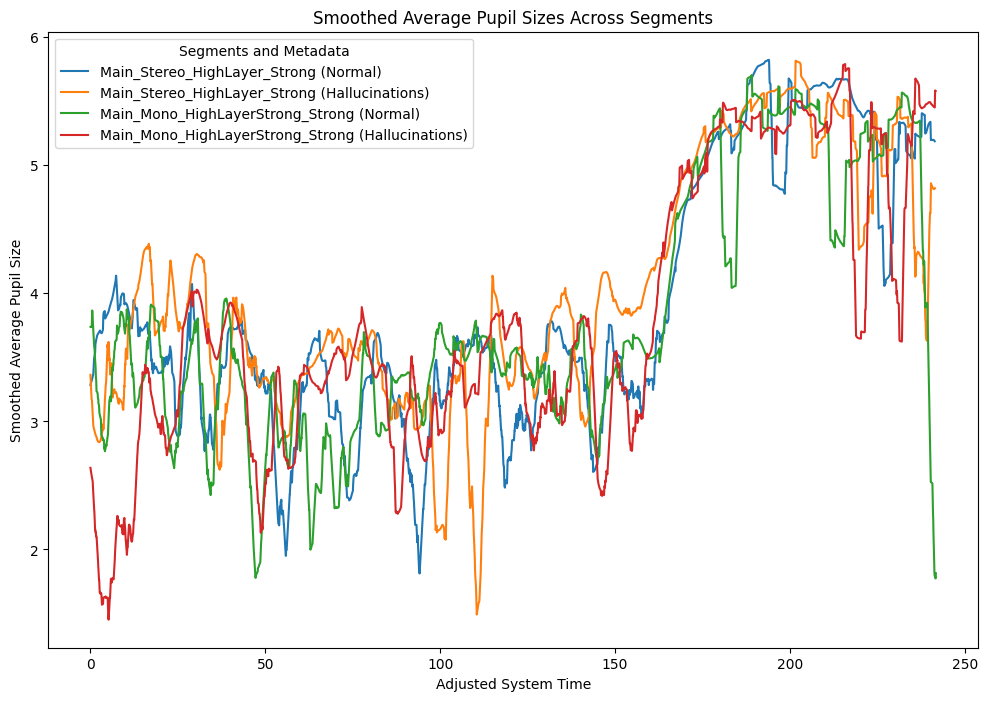

In [ ]:
def plot_average_pupil_size_per_segment(combined_device_data, segment_mapping=None):
    """
    Plots average smoothed pupil sizes across segments on a single graph.
    Optionally overlays the "Luminosity" column.

    Args:
        combined_device_data (pd.DataFrame): DataFrame containing segmented pupil size data.
        segment_mapping (dict): Mapping of segment numbers to metadata (e.g., VideoName, VideoMode).

    Returns:
        None
    """
    plt.figure(figsize=(12, 8))

    # Update segment labels using the mapping if provided
    if segment_mapping:
        combined_device_data = combined_device_data.copy()
        combined_device_data["Segment"] = combined_device_data["Segment"].map(
            lambda x: f"{segment_mapping[int(x.split()[-1])]['VideoName']} ({segment_mapping[int(x.split()[-1])]['VideoMode']})"
            if int(x.split()[-1]) in segment_mapping else x
        )

    # Plot average smoothed pupil size
    sns.lineplot(
        data=combined_device_data,
        x="AdjustedSystemTime",
        y="AverageSmoothedPupilSize",
        hue="Segment",
        palette="tab10",
        linestyle="-",
    )

    # Add titles and labels
    plt.title("Smoothed Average Pupil Sizes Across Segments")
    plt.xlabel("Adjusted System Time")
    plt.ylabel("Smoothed Average Pupil Size")
    plt.legend(title="Segments and Metadata")
    plt.show()


plot_average_pupil_size_per_segment(splitted_device_data, segment_video_mapping)

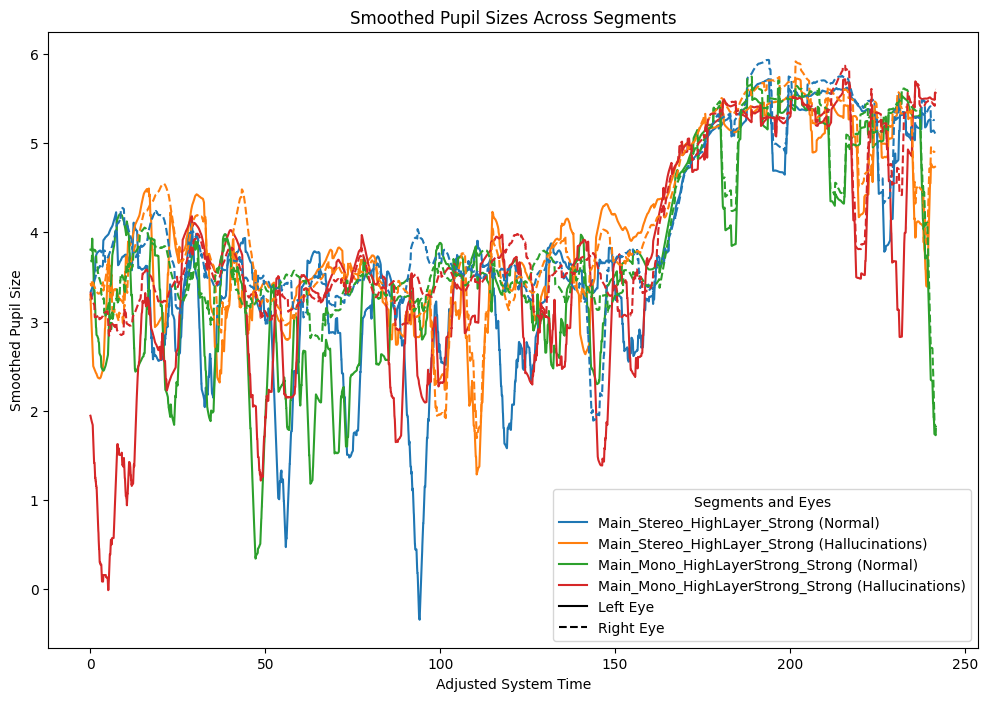

In [ ]:
def plot_smoothed_pupil_size_per_segment(combined_device_data, segment_mapping=None):
    """
    Plots smoothed pupil sizes for right and left eyes on a single graph,
    with different segments represented by separate colors and customized legend based on the mapping.

    Args:
        combined_device_data (pd.DataFrame): DataFrame containing segmented pupil size data.
        segment_mapping (dict): Mapping of segment numbers to metadata (e.g., VideoName, VideoMode).

    Returns:
        None
    """
    plt.figure(figsize=(12, 8))

    # Update segment labels using the mapping if provided
    if segment_mapping:
        combined_device_data = combined_device_data.copy()
        combined_device_data["Segment"] = combined_device_data["Segment"].map(
            lambda x: f"{segment_mapping[int(x.split()[-1])]['VideoName']} ({segment_mapping[int(x.split()[-1])]['VideoMode']})"
            if int(x.split()[-1]) in segment_mapping else x
        )

    # Plot smoothed left pupil size
    left_plot = sns.lineplot(
        data=combined_device_data,
        x="AdjustedSystemTime",
        y="SmoothedLeftPupilSize",
        hue="Segment",
        palette="tab10",
        linestyle="-",
    )

    # Plot smoothed right pupil size
    right_plot = sns.lineplot(
        data=combined_device_data,
        x="AdjustedSystemTime",
        y="SmoothedRightPupilSize",
        hue="Segment",
        palette="tab10",
        linestyle="--",
    )

    # Combine the legend for both eyes
    handles, labels = left_plot.get_legend_handles_labels()
    left_eye_handle = plt.Line2D([], [], color='black', linestyle='-', label='Left Eye')
    right_eye_handle = plt.Line2D([], [], color='black', linestyle='--', label='Right Eye')

    plt.legend(handles=handles[:len(labels) // 2] + [left_eye_handle, right_eye_handle], title="Segments and Eyes")

    # Add titles and labels
    plt.title("Smoothed Pupil Sizes Across Segments")
    plt.xlabel("Adjusted System Time")
    plt.ylabel("Smoothed Pupil Size")
    plt.show()

plot_smoothed_pupil_size_per_segment(splitted_device_data, segment_video_mapping)

### Luminosity

In [ ]:
participant_data["device_data"]['LuminosityMissing'] = (participant_data["device_data"]['Luminosity']<0.1).astype(int)


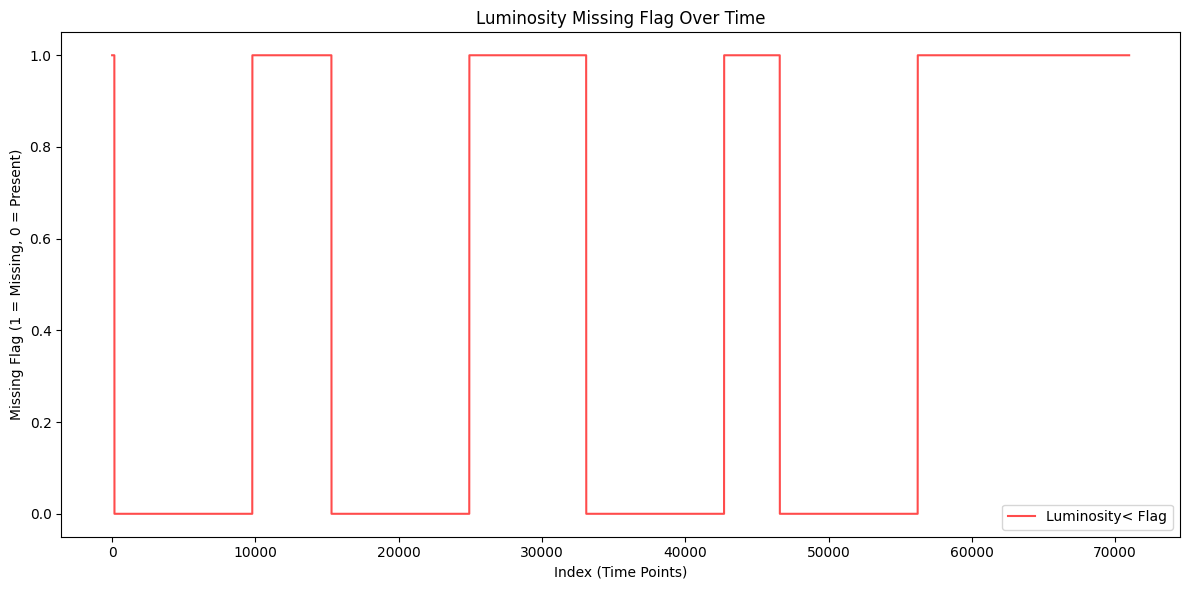

In [ ]:

# Plot the 'LuminosityMissing' flag
plt.figure(figsize=(12, 6))
participant_data["device_data"]['LuminosityMissing'].plot(color='red', alpha=0.7, label='Luminosity< Flag')

# Add title and labels
plt.title("Luminosity Missing Flag Over Time")
plt.xlabel("Index (Time Points)")
plt.ylabel("Missing Flag (1 = Missing, 0 = Present)")

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

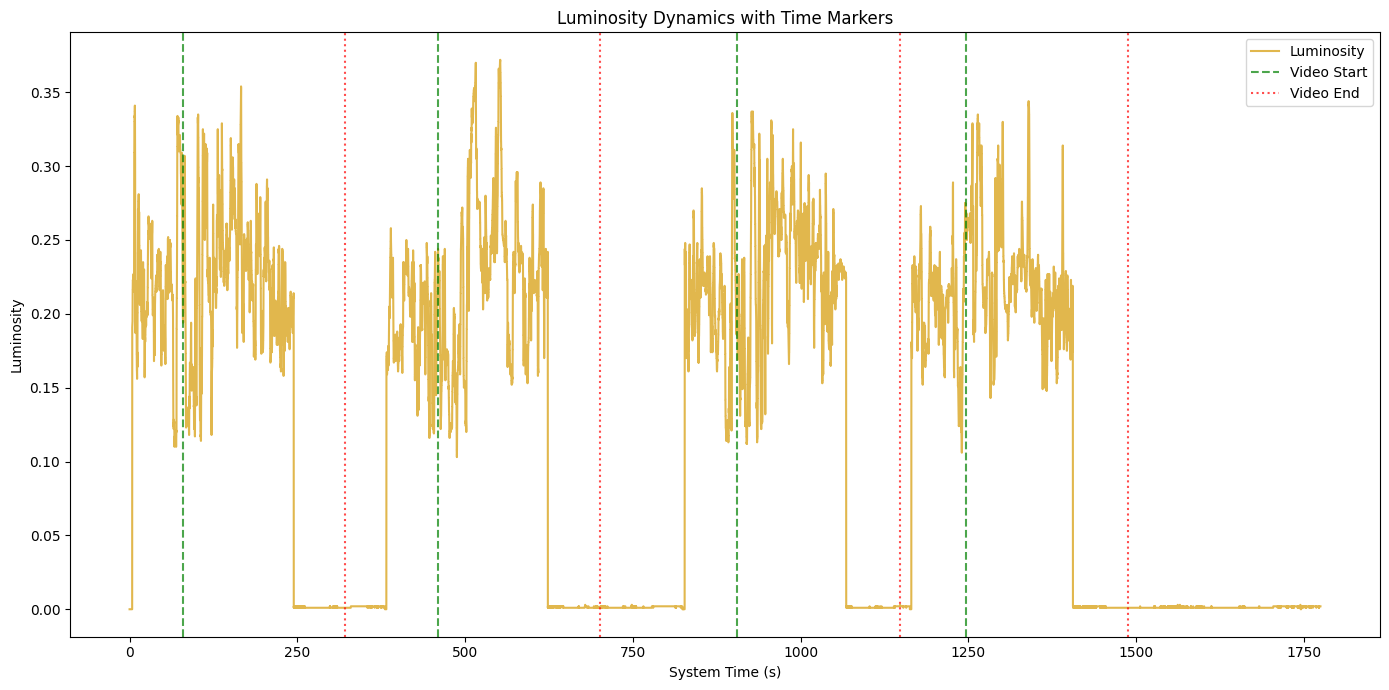

In [ ]:
# Plot luminosity dynamics
plt.figure(figsize=(14, 7))
plt.plot(participant_data["device_data"]["SystemTime"], participant_data["device_data"]["Luminosity"], label="Luminosity", color="goldenrod", alpha=0.8)

# Add vertical lines for video start and end times
for i, start in enumerate(video_start_ecg):
    plt.axvline(x=start, color="green", linestyle="--", alpha=0.7, label="Video Start" if i == 0 else "")

for i, end in enumerate(video_end_ecg):
    plt.axvline(x=end, color="red", linestyle=":", alpha=0.7, label="Video End" if i == 0 else "")

# Customize plot
plt.title("Luminosity Dynamics with Time Markers")
plt.xlabel("System Time (s)")
plt.ylabel("Luminosity")
plt.legend()
plt.tight_layout()
plt.show()

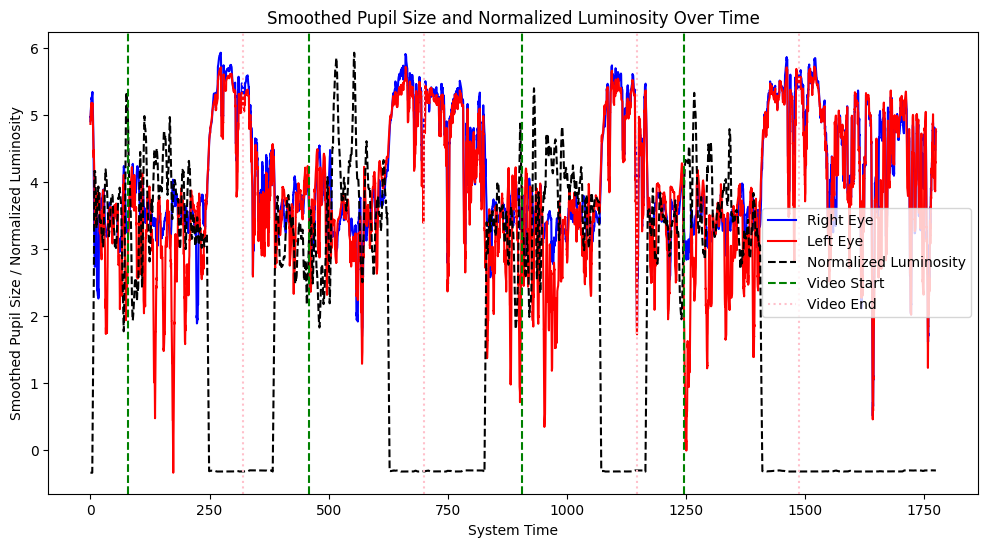

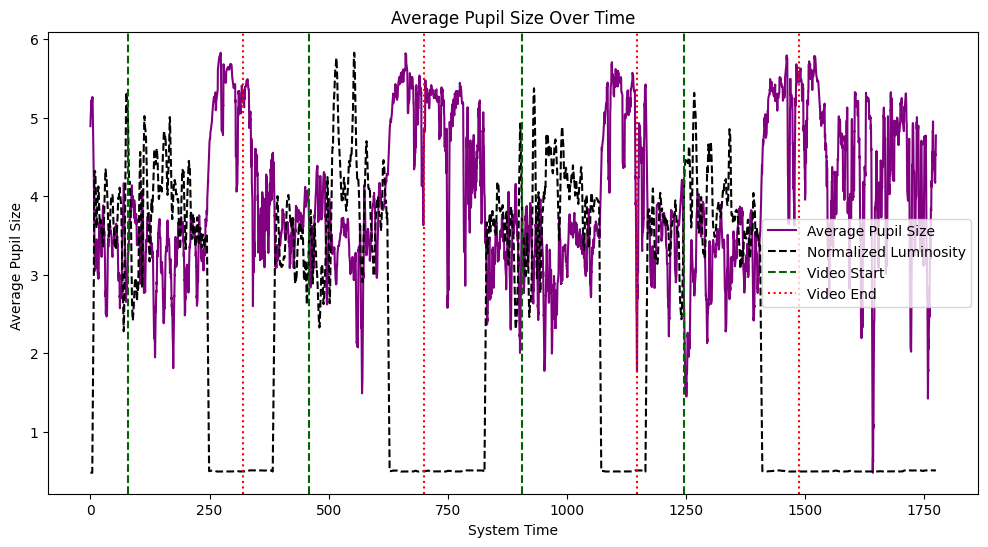

In [ ]:
plot_smoothed_pupil_size(participant_data["device_data"], video_start_ecg, video_end_ecg, include_luminosity=True)
plot_average_pupil_size(participant_data["device_data"], video_start_ecg, video_end_ecg, include_luminosity=True)

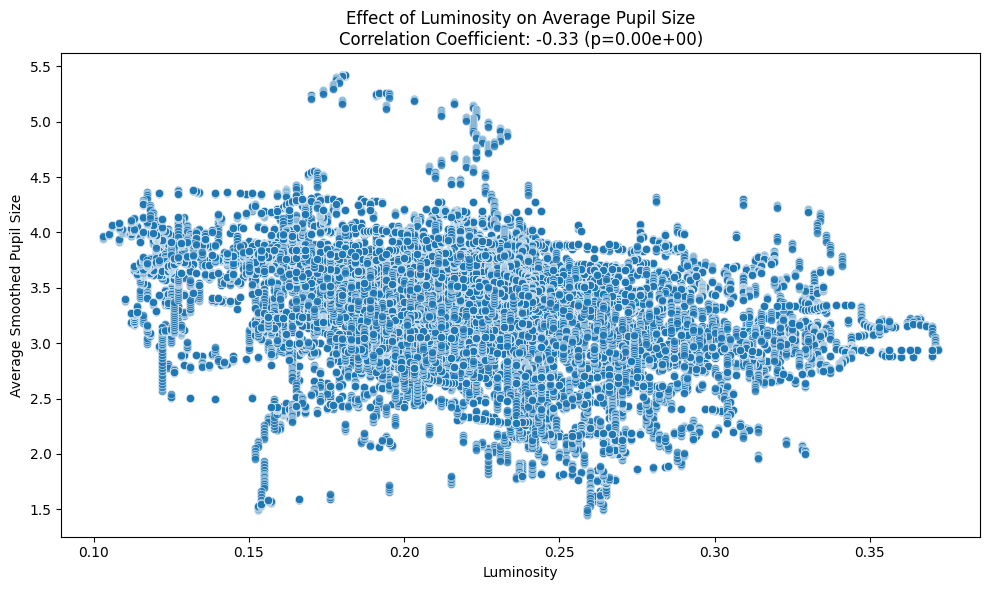

In [ ]:
from scipy.stats import pearsonr

# Filter data where Luminosity is not missing (LuminosityMissing == 0)
filtered_data = participant_data["device_data"][participant_data["device_data"]['LuminosityMissing'] == 0]

# Calculate the correlation coefficient between Luminosity and Average Pupil Size
luminosity = filtered_data['Luminosity']
average_pupil_size = filtered_data['AverageSmoothedPupilSize']

correlation_coefficient, p_value = pearsonr(luminosity, average_pupil_size)

# Visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x=luminosity, y=average_pupil_size, alpha=0.7)
plt.title(f"Effect of Luminosity on Average Pupil Size\nCorrelation Coefficient: {correlation_coefficient:.2f} (p={p_value:.2e})")
plt.xlabel("Luminosity")
plt.ylabel("Average Smoothed Pupil Size")
plt.tight_layout()
plt.show()

correlation_coefficient, p_value
plt.show()

In [ ]:
print(participant_data["device_data"])

       Id  SegmentIndex                         VideoName       VideoMode  \
0       1             0                               NaN             NaN   
1       1             1      Main_Stereo_HighLayer_Strong          Normal   
2       1             1      Main_Stereo_HighLayer_Strong          Normal   
3       1             1      Main_Stereo_HighLayer_Strong          Normal   
4       1             1      Main_Stereo_HighLayer_Strong          Normal   
...    ..           ...                               ...             ...   
70975   1             4  Main_Mono_HighLayerStrong_Strong  Hallucinations   
70976   1             4  Main_Mono_HighLayerStrong_Strong  Hallucinations   
70977   1             4  Main_Mono_HighLayerStrong_Strong  Hallucinations   
70978   1             4  Main_Mono_HighLayerStrong_Strong  Hallucinations   
70979   1             4  Main_Mono_HighLayerStrong_Strong  Hallucinations   

       QuestionIndex  SystemTime          DevicePosition  \
0              

### (More on EyeTracking)

In [ ]:
!apt-get update
!apt-get install -y build-essential libgtk-3-dev libwebkit2gtk-4.0-dev \
    libgstreamer1.0-dev libgstreamer-plugins-base1.0-dev
!pip install wxPython --only-binary wxPython
!pip install -U pip setuptools wheel
!pip install wxPython --no-cache-dir --verbose
!pip install wxPython==4.2.0

!pip install psychopy


Streaming output truncated to the last 5000 lines.
  [332/939] Compiling sip/cpp/sip_corewxPreviewCanvas.cpp
  [333/939] Compiling sip/cpp/sip_corewxPowerResourceBlocker.cpp
  [334/939] Compiling sip/cpp/sip_corewxPowerResource.cpp
  [335/939] Compiling sip/cpp/sip_corewxFontMapper.cpp
  [336/939] Compiling sip/cpp/sip_corewxPowerEvent.cpp
  [337/939] Compiling sip/cpp/sip_corewxPostScriptDC.cpp
  [338/939] Compiling sip/cpp/sip_corewxContextMenuEvent.cpp
  [339/939] Compiling sip/cpp/sip_corewxContextHelpButton.cpp
  [340/939] Compiling sip/cpp/sip_corewxBufferedDC.cpp
  [341/939] Compiling sip/cpp/sip_corewxPosition.cpp
  [342/939] Compiling sip/cpp/sip_corewxPopupWindow.cpp
  [343/939] Compiling sip/cpp/sip_corewxFontInfo.cpp
  [344/939] Compiling sip/cpp/sip_corewxPopupTransientWindow.cpp
  [345/939] Compiling sip/cpp/sip_corewxPointList_iterator.cpp
  [346/939] Compiling sip/cpp/sip_corewxFontEnumerator.cpp
  [347/939] Compiling sip/cpp/sip_corewxContextHelp.cpp
  [348/939] Compil

In [ ]:
eye_data = participant_data["device_data"]
eye_data.columns

Index(['Id', 'SegmentIndex', 'VideoName', 'VideoMode', 'QuestionIndex',
       'SystemTime', 'DevicePosition', 'DeviceRotation',
       'CombinedEyeDirection', 'CombinedEyeOrigin', 'LeftEyeOpeness',
       'LeftEyeOrigin', 'LeftEyeDirection', 'LeftEyePositionInSensorArea',
       'LeftEyePupilSize', 'RightEyeOpeness', 'RightEyeOrigin',
       'RightEyeDirection', 'RightEyePositionInSensorArea',
       'RightEyePupilSize', 'Phase', 'Luminosity', 'Unnamed: 22',
       'SegmentChanged', 'SmoothedRightPupilSize', 'SmoothedLeftPupilSize',
       'AverageSmoothedPupilSize', 'LuminosityMissing'],
      dtype='object')

In [ ]:
eye_data = participant_data["device_data"].copy()
# Rename relevant columns for consistency
eye_data.rename(columns={
    'LeftEyeDirection': 'LeftGaze',
    'RightEyeDirection': 'RightGaze',
    'ExperimentSecond': 'Timestamp'
}, inplace=True)
eye_data

,Id,SegmentIndex,VideoName,VideoMode,QuestionIndex,SystemTime,DevicePosition,DeviceRotation,CombinedEyeDirection,CombinedEyeOrigin,...,RightEyePositionInSensorArea,RightEyePupilSize,Phase,Luminosity,Unnamed: 22,SegmentChanged,SmoothedRightPupilSize,SmoothedLeftPupilSize,AverageSmoothedPupilSize,LuminosityMissing
0,1,0,NaN,NaN,0,0.036,"(0.278, 1.847, -0.238)","(2.446, 3.239, 4.385)","(-0.138, 0.071, 0.988)","(4.205, -5.730, -19.968)",...,"(0.418, 0.711, 0.000)",4.91,NaN,0.000,NaN,True,4.910000,4.870000,4.890000,1
1,1,1,Main_Stereo_HighLayer_Strong,Normal,0,0.086,"(0.276, 1.846, -0.238)","(2.431, 3.247, 4.589)","(0.051, 0.062, 0.997)","(-28.135, -7.391, -18.305)",...,"(0.421, 0.717, 0.000)",4.98,Countdown,0.000,NaN,True,4.945000,4.905000,4.925000,1
2,1,1,Main_Stereo_HighLayer_Strong,Normal,0,0.086,"(0.276, 1.846, -0.238)","(2.431, 3.247, 4.589)","(0.051, 0.062, 0.997)","(-28.135, -7.391, -18.305)",...,"(0.421, 0.717, 0.000)",4.98,Countdown,0.000,NaN,False,4.956667,4.916667,4.936667,1
3,1,1,Main_Stereo_HighLayer_Strong,Normal,0,0.112,"(0.257, 1.841, -0.229)","(3.358, 3.034, 7.265)","(0.058, 0.064, 0.996)","(-28.181, -7.376, -18.317)",...,"(0.421, 0.716, 0.000)",5.01,Countdown,0.000,NaN,False,4.970000,4.922500,4.946250,1
4,1,1,Main_Stereo_HighLayer_Strong,Normal,0,0.136,"(0.262, 1.842, -0.230)","(3.295, 3.033, 6.756)","(0.063, 0.064, 0.996)","(-28.218, -7.356, -18.361)",...,"(0.421, 0.716, 0.000)",5.01,Countdown,0.000,NaN,False,4.978000,4.934000,4.956000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70975,1,4,Main_Mono_HighLayerStrong_Strong,Hallucinations,0,1774.403,"(0.991, 1.835, -0.857)","(7.556, 315.553, 0.418)","(-0.235, 0.174, 0.956)","(9.512, -7.320, -18.283)",...,"(0.437, 0.700, 0.000)",5.29,Recording,0.002,NaN,False,4.757333,4.785333,4.771333,1
70976,1,4,Main_Mono_HighLayerStrong_Strong,Hallucinations,0,1774.426,"(0.991, 1.835, -0.857)","(7.556, 315.635, 0.428)","(-0.278, 0.180, 0.944)","(18.668, -7.252, -18.531)",...,"(0.437, 0.700, 0.000)",5.27,Recording,0.002,NaN,False,4.757444,4.786389,4.771917,1
70977,1,4,Main_Mono_HighLayerStrong_Strong,Hallucinations,0,1774.461,"(0.991, 1.835, -0.856)","(7.596, 315.828, 0.450)","(-0.262, 0.179, 0.948)","(15.873, -7.254, -18.471)",...,"(0.437, 0.699, 0.000)",5.27,Recording,0.002,NaN,False,4.757222,4.787222,4.772222,1
70978,1,4,Main_Mono_HighLayerStrong_Strong,Hallucinations,0,1774.486,"(0.991, 1.835, -0.856)","(7.613, 315.948, 0.465)","(-0.213, 0.170, 0.962)","(6.439, -7.277, -18.251)",...,"(0.437, 0.698, 0.000)",5.27,Recording,0.002,NaN,False,4.757056,4.788167,4.772611,1


In [ ]:
def calculate_velocity(data, col_prefix):
    gaze_x = data[f"{col_prefix}Gaze"].apply(lambda x: eval(x)[0])  # X-coordinates
    gaze_y = data[f"{col_prefix}Gaze"].apply(lambda x: eval(x)[1])  # Y-coordinates
    velocity_x = np.gradient(gaze_x)
    velocity_y = np.gradient(gaze_y)
    velocity = np.sqrt(velocity_x**2 + velocity_y**2)
    return velocity

# Compute velocities for left and right gaze
eye_data['LeftVelocity'] = calculate_velocity(eye_data, 'Left')
eye_data['RightVelocity'] = calculate_velocity(eye_data, 'Right')


In [ ]:
# Normalize velocities by standard deviation
eye_data['LeftVelocityNorm'] = eye_data['LeftVelocity'] / eye_data['LeftVelocity'].std()
eye_data['RightVelocityNorm'] = eye_data['RightVelocity'] / eye_data['RightVelocity'].std()


In [ ]:
# Define threshold for micro-saccades (6 SD is common)
threshold = 6

eye_data['LeftMicroSaccade'] = eye_data['LeftVelocityNorm'] > threshold
eye_data['RightMicroSaccade'] = eye_data['RightVelocityNorm'] > threshold


In [ ]:
from psychopy.visual import Window, Circle
from psychopy.core import wait

# Setup PsychoPy Window
win = Window(size=(800, 600), units="pix", fullscr=False)

# Visualize gaze positions
for _, row in eye_data.iterrows():
    left_gaze = eval(row['LeftGaze'])
    right_gaze = eval(row['RightGaze'])

    # Draw left and right gaze points
    Circle(win, pos=left_gaze[:2], radius=5, fillColor='red').draw()
    Circle(win, pos=right_gaze[:2], radius=5, fillColor='blue').draw()
    win.flip()
    wait(0.01)  # Adjust playback speed


pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


ImportError: Library "GLU" not found.